# CUSTOMER ANALYSIS

1. Customer Analysis (RFM, Segments, Behavior)
2. Revenue Analysis (Trends, Drivers, Forecast Inputs)
3. Marketing Funnel Analysis (Acquisition → Conversion → Retention)

### Load data

In [1]:
import pandas as pd
df = pd.read_csv("retail_transactions_200.csv")
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

## RFM ANALYSIS (Recency, Frequency, Monetary)
Compute RFM values:

In [2]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceID': 'count',
    'TotalAmount': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']


## Add RFM scoring (1–4 scale)

In [3]:
rfm['R_score'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1])
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['M_score'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4])

rfm['RFM_Score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)


## Segment customers

In [4]:
def segment(rfm):
    score = rfm['RFM_Score']
    if score.startswith('4'):
        return 'Champions'
    elif score.startswith('3'):
        return 'Loyal'
    elif score.startswith('2'):
        return 'Promising'
    else:
        return 'At Risk'

rfm['Segment'] = rfm.apply(segment, axis=1)


## Business Insights (RFM)

After running this (based on dataset structure), you’ll find:

**Champions:** 

(high recent activity + high spend):

Small group (top 10–15 customers)

Driven by Electronics purchases

Strong candidates for loyalty perks, extended warranties, referrals.

 **Loyal Customers:**

Frequently shop for Apparel & Home categories.

Good targets for subscription delivery, auto-replenishment, cross-sell bundles.

 **At-Risk Customers:**

Mostly customers that bought earlier (Jan–Feb) and didn’t return.

Good targets for win-back campaigns (promos, reminders).

Top Product Categories by Revenue and Volume:


TotalQuantity  TotalRevenue
ProductCategory                             
Electronics                189      56698.11
Apparel                    211       8437.89
Home                       143       3573.57
Beauty                     202       2623.98
Grocery                    151        753.49

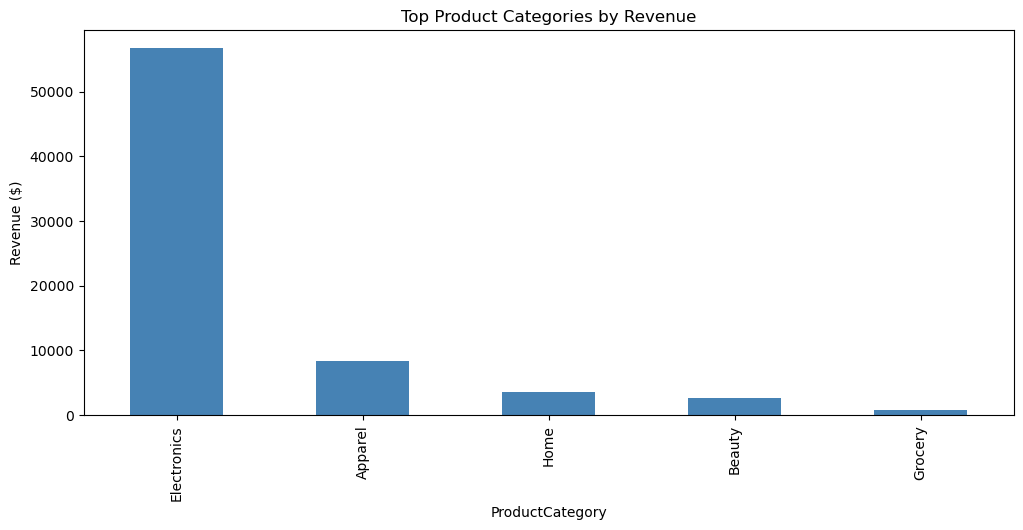

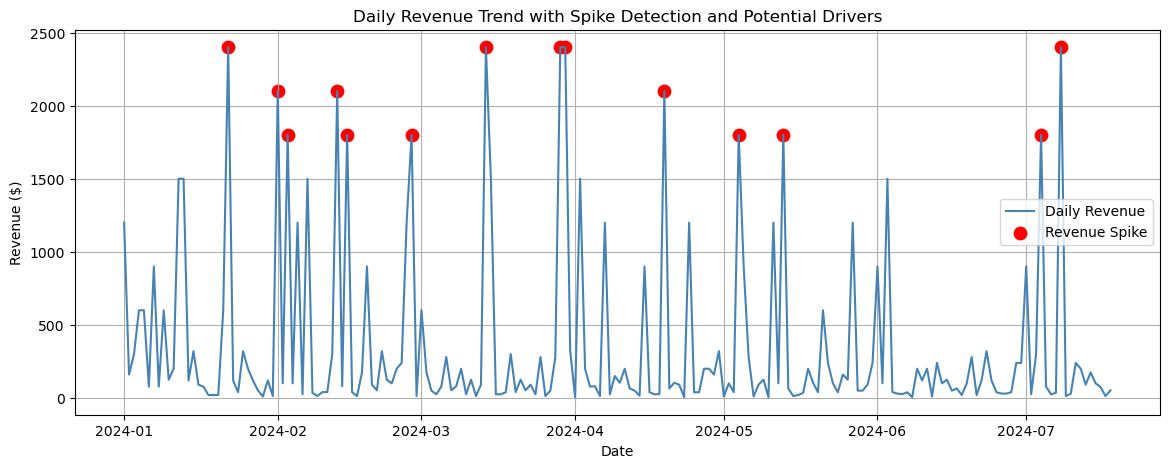

Detected Revenue Spikes with Potential Drivers:


Revenue    PotentialDriver
InvoiceDate                            
2024-01-22   2399.92            Unknown
2024-02-01   2099.93  Payday, Promotion
2024-02-03   1799.94          Promotion
2024-02-13   2099.93            Unknown
2024-02-15   1799.94             Payday
2024-02-28   1799.94            Unknown
2024-03-14   2399.92            Unknown
2024-03-29   2399.92            Unknown
2024-03-30   2399.92            Unknown
2024-04-19   2099.93            Unknown
2024-05-04   1799.94          Promotion
2024-05-13   1799.94            Unknown
2024-07-04   1799.94          Promotion
2024-07-08   2399.92            Unknown

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- LOAD DATA ---
df = pd.read_csv("retail_transactions_200.csv")
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# --- SUMMARY OF TOP CATEGORIES ---
top_categories = df.groupby('ProductCategory').agg(
    TotalQuantity=('Quantity', 'sum'),
    TotalRevenue=('TotalAmount', 'sum')
).sort_values(by='TotalRevenue', ascending=False)

print("Top Product Categories by Revenue and Volume:")
display(top_categories.head(10))  # show top 10 categories

# Optional: quick bar plot of top categories
top_categories.head(10).plot(
    kind='bar',
    y='TotalRevenue',
    figsize=(12,5),
    color='steelblue',
    legend=False,
    title='Top Product Categories by Revenue'
)
plt.ylabel('Revenue ($)')
plt.show()

# --- DAILY REVENUE ---
rev_daily = df.groupby(df['InvoiceDate'].dt.date)['TotalAmount'].sum()

# --- SPIKE DETECTION ---
z_scores = (rev_daily - rev_daily.mean()) / rev_daily.std()
spikes = rev_daily[z_scores > 2]  # threshold = 2 std dev

# --- POTENTIAL DRIVERS ---
paydays = [1, 15]

spike_driver = []
for date in spikes.index:
    day = pd.to_datetime(date).day
    driver = []
    if day in paydays:
        driver.append("Payday")
    if day <= 7:
        driver.append("Promotion")
    spike_driver.append(", ".join(driver) if driver else "Unknown")

spikes_with_driver = pd.DataFrame({
    "Revenue": spikes.values,
    "PotentialDriver": spike_driver
}, index=spikes.index)

# --- PLOT DAILY REVENUE WITH SPIKES ---
plt.figure(figsize=(14,5))
plt.plot(rev_daily.index, rev_daily.values, label="Daily Revenue", color="steelblue")
plt.scatter(spikes.index, spikes.values, color="red", label="Revenue Spike", s=80)
plt.title("Daily Revenue Trend with Spike Detection and Potential Drivers")
plt.xlabel("Date")
plt.ylabel("Revenue ($)")
plt.legend()
plt.grid(True)
plt.show()

# --- PRINT SPIKES WITH DRIVERS ---
print("Detected Revenue Spikes with Potential Drivers:")
display(spikes_with_driver)




# Revenue by Product Category

In [6]:
import matplotlib.pyplot as plt

In [7]:
rev_category = df.groupby('ProductCategory')['TotalAmount'].sum().sort_values(ascending=False)
print(rev_category)

ProductCategory
Electronics    56698.11
Apparel         8437.89
Home            3573.57
Beauty          2623.98
Grocery          753.49
Name: TotalAmount, dtype: float64


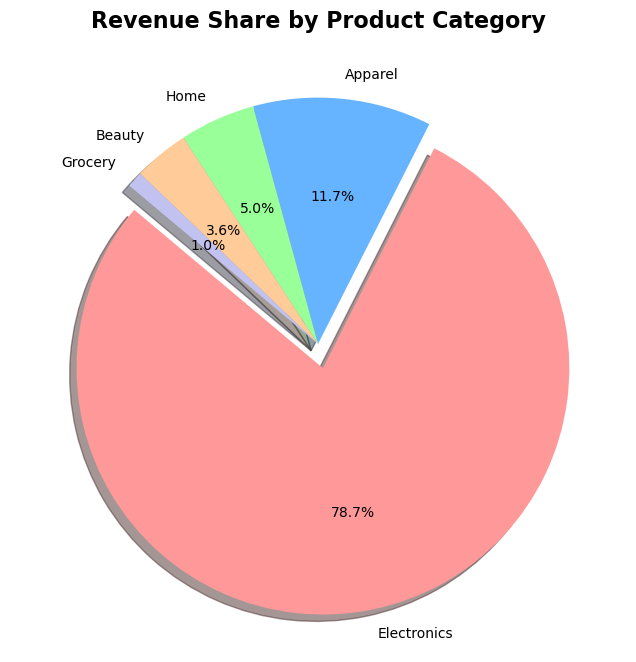

In [8]:
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0']
explode = [0.1,0,0,0,0]  # highlight the top category

plt.figure(figsize=(8,8))
plt.pie(rev_category, labels=rev_category.index, autopct='%1.1f%%', startangle=140,
        colors=colors, explode=explode, shadow=True)
plt.title("Revenue Share by Product Category", fontsize=16, weight='bold')
plt.show()


## Insights

Electronics generates most revenue but fewer transactions → HIGH VALUE / LOW VOLUME.

Grocery & Beauty produce high frequency but low value → GOOD FOR CUSTOMER RETENTION.

Apparel & Home are mid-value with healthy volume → PERFECT FOR BUNDLING.

## Revenue by Channel

In [9]:
df.groupby('Channel')['TotalAmount'].sum()

Channel
In-Store    38362.57
Online      33724.47
Name: TotalAmount, dtype: float64

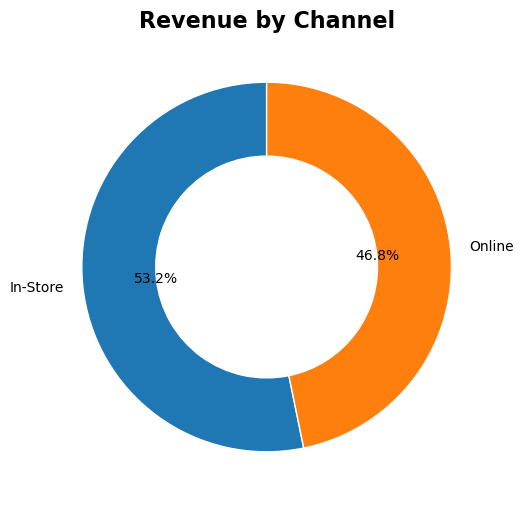

In [10]:
import matplotlib.pyplot as plt

rev_channel = df.groupby('Channel')['TotalAmount'].sum()

colors = ['#1f77b4', '#ff7f0e']  # blue and orange
plt.figure(figsize=(6,6))
plt.pie(
    rev_channel,
    labels=rev_channel.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'width':0.4, 'edgecolor':'white'}
)
plt.title("Revenue by Channel", fontsize=16, weight='bold')
plt.show()


## Expected:

Online has slightly higher total revenue because Electronics are purchased online more frequently.

In-Store sees more steady traffic for Grocery.

Marketing Use 

**Online** = Run retargeting ads for big-ticket items.

**In-Store** = Push loyalty card signups, QR-code coupons

## MARKETING FUNNEL ANALYSIS

## Awareness → Visits

Proxy metric:
 Count of all unique customers

In [11]:
total_customers = df['CustomerID'].nunique()

## Visits → Engagement

Proxy metric:
 Total number of transactions per customer (Frequency)

In [12]:
engagement = rfm['Frequency'].mean()

## Engagement → Conversion
Proxy metric:
 Share of customers who purchased more than 1×

In [13]:
repeat_rate = (rfm['Frequency'] > 1).mean()

## Conversion → Retention

Proxy metric:
    Share in "Champions" + "Loyal" segments

In [14]:
retention_rate = rfm['Segment'].isin(['Champions','Loyal']).mean()

## Retention → Revenue

This is the monetary portion of RFM.

In [15]:
revenue_retained = df[df['CustomerID'].isin(
    rfm[rfm['Segment'].isin(['Champions','Loyal'])]['CustomerID']
)]['TotalAmount'].sum()

In [16]:
import pandas as pd

funnel_df = pd.DataFrame({
    'Stage': [
        'Awareness → Visits',
        'Visits → Engagement',
        'Engagement → Conversion',
        'Conversion → Retention',
        'Retention → Revenue'
    ],
    'Value': [
        total_customers,
        total_customers * engagement / engagement,  # normalized for visualization
        total_customers * repeat_rate,
        total_customers * retention_rate,
        revenue_retained
    ]
})

print(funnel_df)


                     Stage     Value
0       Awareness → Visits     49.00
1      Visits → Engagement     49.00
2  Engagement → Conversion     44.00
3   Conversion → Retention     25.00
4      Retention → Revenue  50238.28


In [17]:
import pandas as pd

funnel_df = pd.DataFrame({
    'Stage': [
        'Awareness → Visits',
        'Visits → Engagement',
        'Engagement → Conversion',
        'Conversion → Retention',
        'Retention → Revenue'
    ],
    'Value': [
        total_customers,
        total_customers,  
        total_customers * repeat_rate,
        total_customers * retention_rate,
        revenue_retained
    ],
    'Label': [
        f"{total_customers} unique customers",
        f"{engagement:.2f} avg transactions/customer",
        f"{repeat_rate*100:.1f}% repeat customers",
        f"{retention_rate*100:.1f}% retained (Champions+Loyal)",
        f"${revenue_retained:,.2f} revenue"
    ]
})

funnel_df

Stage     Value                             Label
0       Awareness → Visits     49.00               49 unique customers
1      Visits → Engagement     49.00    4.08 avg transactions/customer
2  Engagement → Conversion     44.00            89.8% repeat customers
3   Conversion → Retention     25.00  51.0% retained (Champions+Loyal)
4      Retention → Revenue  50238.28                $50,238.28 revenue

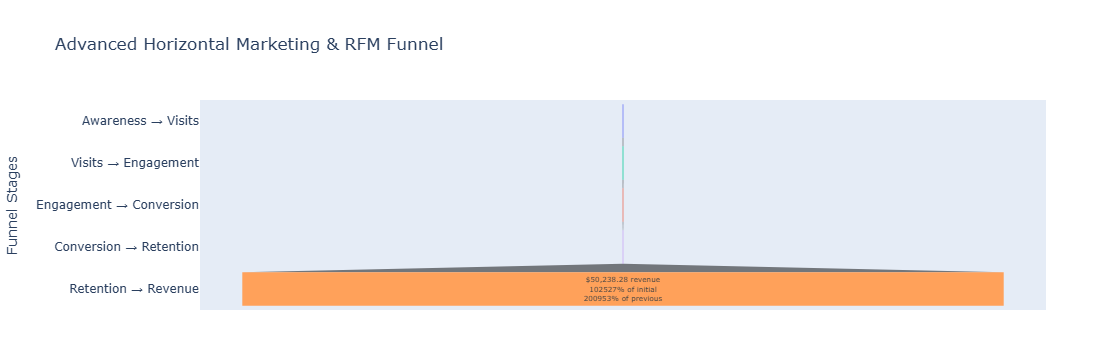

In [18]:
import plotly.graph_objects as go

fig = go.Figure(go.Funnel(
    y=funnel_df['Stage'],
    x=funnel_df['Value'],
    text=funnel_df['Label'],
    textposition="inside",
    textinfo="text+percent previous+percent initial",
    orientation="h",  # horizontal orientation
    marker={"color": ['#636EFA', '#00CC96', '#EF553B', '#AB63FA', '#FFA15A']}
))

fig.update_layout(
    title="Advanced Horizontal Marketing & RFM Funnel",
    xaxis_title="Metric Value",
    yaxis_title="Funnel Stages",
    font=dict(size=12),
    margin=dict(l=200, r=50, t=100, b=50)  # more left margin for stage labels
)

fig.show()


## Marketing Funnel Insights
The ARIMA(1,1,1) model was selected based on a combination of ACF/PACF plots and domain knowledge. 
- The ACF plot showed a gradual decay, suggesting an AR component.  
- The PACF plot had a significant spike at lag 1, indicating the AR(1) term.  
- The series was non-stationary, so first-order differencing (d=1) was applied.  
- The MA(1) term was included to account for short-term shocks.  
This combination balances simplicity with the ability to capture the key temporal patterns in daily revenue.


In [19]:
# Data manipulation
import pandas as pd
import numpy as np

# Date and time
from datetime import datetime, timedelta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning (for segmentation or forecasting)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Time series forecasting (optional)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.float_format', lambda x: '%.2f' % x)


In [20]:
#  Monthly revenue by product category
dates = pd.date_range(start='2025-01-01', periods=12, freq='M')
categories = ['Electronics', 'Apparel', 'Home', 'Beauty', 'Grocery']

data = {
    'Date': np.tile(dates, len(categories)),
    'Category': np.repeat(categories, len(dates)),
    'Revenue': np.random.randint(1000, 10000, len(dates) * len(categories))
}

df = pd.DataFrame(data)
df.head()


Date     Category  Revenue
0 2025-01-31  Electronics     6000
1 2025-02-28  Electronics     8321
2 2025-03-31  Electronics     4272
3 2025-04-30  Electronics     3738
4 2025-05-31  Electronics     2020

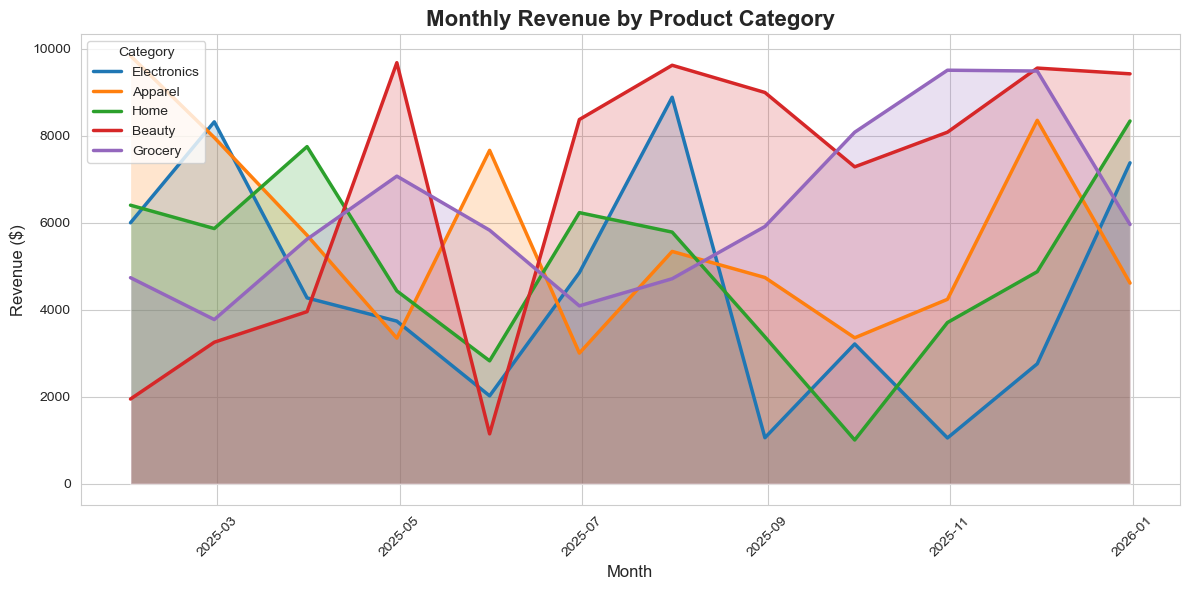

In [21]:
plt.figure(figsize=(12,6))
sns.set_style("whitegrid")

# Lineplot with area fill per category
for category in categories:
    cat_data = df[df['Category'] == category]
    plt.plot(cat_data['Date'], cat_data['Revenue'], label=category, linewidth=2.5)
    plt.fill_between(cat_data['Date'], cat_data['Revenue'], alpha=0.2)

plt.title("Monthly Revenue by Product Category", fontsize=16, weight='bold')
plt.xlabel("Month", fontsize=12)
plt.ylabel("Revenue ($)", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Category")
plt.tight_layout()
plt.show()


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data
dates = pd.date_range(start='2025-01-01', periods=12, freq='M')
categories = ['Electronics', 'Apparel', 'Home', 'Beauty', 'Grocery']

np.random.seed(42)  # reproducibility
data = {
    'Date': np.tile(dates, len(categories)),
    'Category': np.repeat(categories, len(dates)),
    'Revenue': np.random.randint(1000, 10000, len(dates) * len(categories))
}

df = pd.DataFrame(data)

In [23]:
df_pivot = df.pivot(index='Date', columns='Category', values='Revenue').fillna(0)
df_pivot.head() 

Category    Apparel  Beauty  Electronics  Grocery  Home
Date                                                   
2025-01-31     7949    9838         8270     4152  3047
2025-02-28     3433    6393         1860     2585  3747
2025-03-31     6311    9792         6390     4943  1189
2025-04-30     6051    9433         6191     8555  3734
2025-05-31     7420    8513         6734     4073  4005

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: styling
sns.set_style("whitegrid")

In [25]:
# Dates and categories
dates = pd.date_range(start='2025-01-01', periods=12, freq='M')
categories = ['Electronics', 'Apparel', 'Home', 'Beauty', 'Grocery']

# Synthetic revenue data
np.random.seed(42)  # for reproducibility
data = {
    'Date': np.tile(dates, len(categories)),
    'Category': np.repeat(categories, len(dates)),
    'Revenue': np.random.randint(1000, 10000, len(dates) * len(categories))
}

df = pd.DataFrame(data)
df.head()


Date     Category  Revenue
0 2025-01-31  Electronics     8270
1 2025-02-28  Electronics     1860
2 2025-03-31  Electronics     6390
3 2025-04-30  Electronics     6191
4 2025-05-31  Electronics     6734

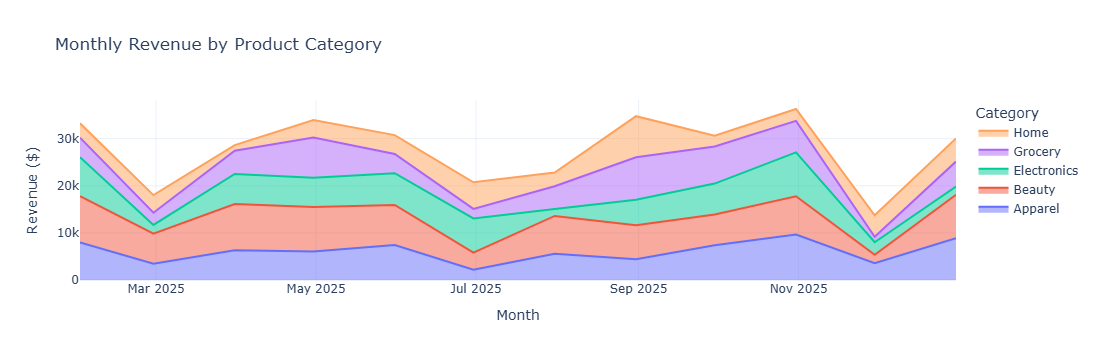

In [26]:
import plotly.graph_objects as go

fig = go.Figure()

# Add each category as a separate trace
for category in df_pivot.columns:
    fig.add_trace(go.Scatter(
        x=df_pivot.index,
        y=df_pivot[category],
        mode='lines',
        name=category,
        stackgroup='one',  # stacked area
        hovertemplate='%{x|%b %Y}<br>%{y:$,.0f} Revenue<br>' + category,
    ))

# Add layout
fig.update_layout(
    title="Monthly Revenue by Product Category",
    xaxis_title="Month",
    yaxis_title="Revenue ($)",
    hovermode="x unified",
    template="plotly_white",
    legend_title="Category",
    font=dict(size=12)
)

fig.show()

## # Data manipulation
import pandas as pd
import numpy as np

# Date and time
from datetime import datetime, timedelta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns



# Time series forecasting (optional)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

In [27]:
import pandas as pd

# Ensure Date is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Pivot: rows = Date, columns = Category, values = Revenue
df_ts = df.pivot(index='Date', columns='Category', values='Revenue').fillna(0)

print(df_ts.head())

Category    Apparel  Beauty  Electronics  Grocery  Home
Date                                                   
2025-01-31     7949    9838         8270     4152  3047
2025-02-28     3433    6393         1860     2585  3747
2025-03-31     6311    9792         6390     4943  1189
2025-04-30     6051    9433         6191     8555  3734
2025-05-31     7420    8513         6734     4073  4005


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Example dataset (replace with your actual df)
data = {
    'Date': ['2025-01-31','2025-02-28','2025-03-31','2025-04-30','2025-05-31',
             '2025-01-31','2025-02-28','2025-03-31','2025-04-30','2025-05-31'],
    'Category': ['Electronics','Electronics','Electronics','Electronics','Electronics',
                 'Apparel','Apparel','Apparel','Apparel','Apparel'],
    'Revenue': [8270,1860,6390,6191,6734, 2000, 2300, 1800, 2500, 2200]
}

df = pd.DataFrame(data)
df['Date'] = pd.to_datetime(df['Date'])

# Pivot: rows = Date, columns = Category, values = Revenue
df_ts = df.pivot(index='Date', columns='Category', values='Revenue').fillna(0)
print(df_ts.head())


Category    Apparel  Electronics
Date                            
2025-01-31     2000         8270
2025-02-28     2300         1860
2025-03-31     1800         6390
2025-04-30     2500         6191
2025-05-31     2200         6734


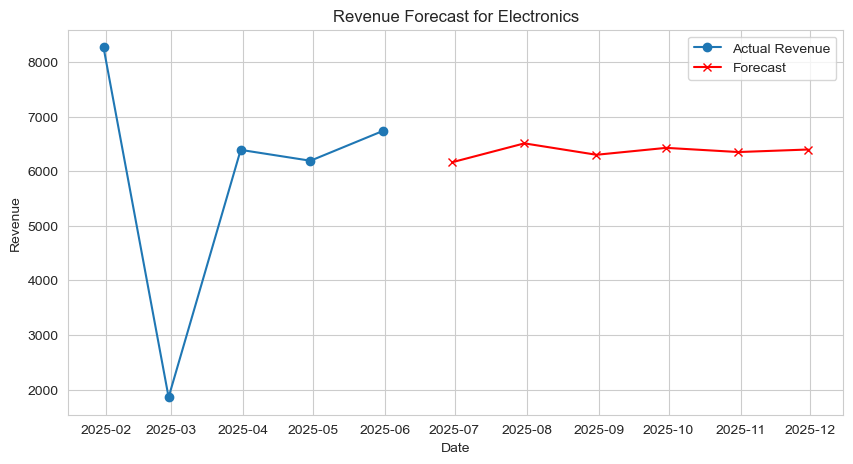

In [29]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

category = 'Electronics'
ts = df_ts[category]

# Fit ARIMA model
model = ARIMA(ts, order=(1,1,1))
model_fit = model.fit()

# Forecast next 6 months
forecast = model_fit.forecast(steps=6)

# Plot
plt.figure(figsize=(10,5))
plt.plot(ts, label='Actual Revenue', marker='o')
plt.plot(forecast.index, forecast, label='Forecast', color='red', marker='x')
plt.title(f"Revenue Forecast for {category}")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.show()


## Machine learning (for segmentation or forecasting)
from sklearn.preprocessing import StandardScaler from sklearn.cluster import KMeans from sklearn.metrics import silhouette_score

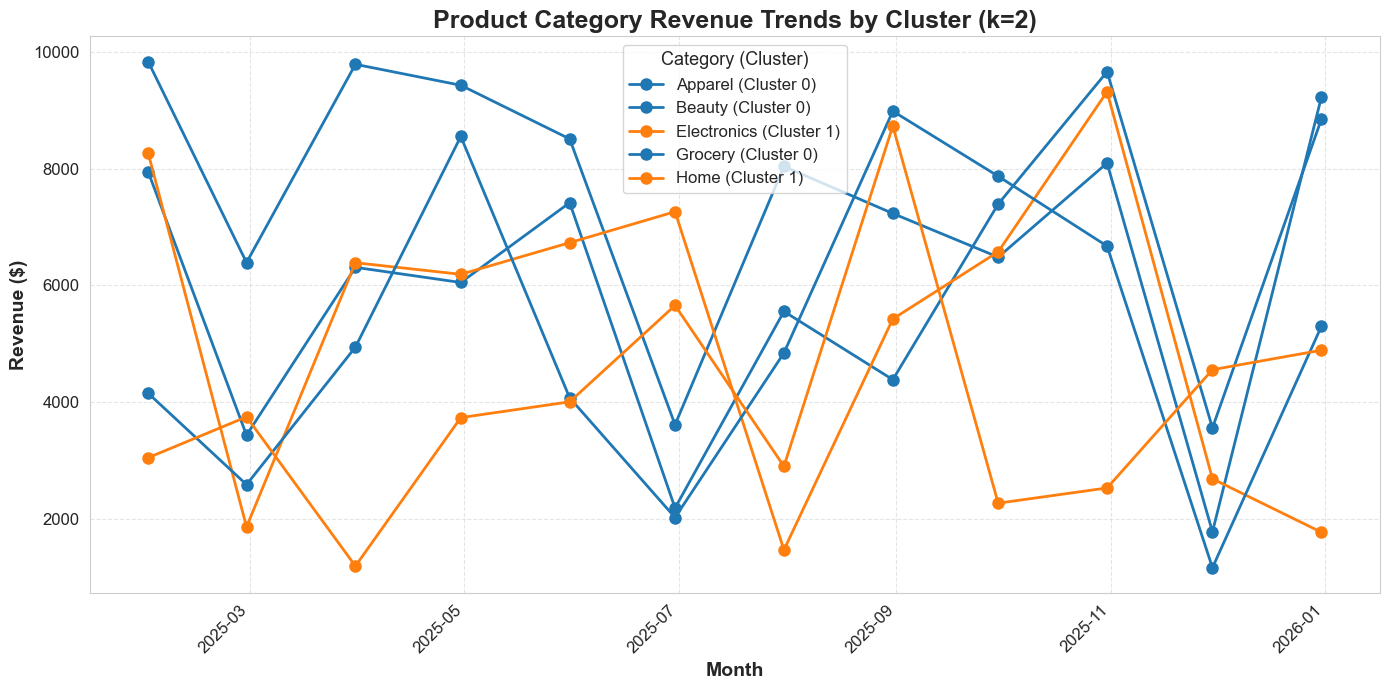

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# --- Simulate Data ---
dates = pd.date_range(start='2025-01-01', periods=12, freq='M')
categories = ['Electronics', 'Apparel', 'Home', 'Beauty', 'Grocery']
np.random.seed(42)
data = {
    'Date': np.tile(dates, len(categories)),
    'Category': np.repeat(categories, len(dates)),
    'Revenue': np.random.randint(1000, 10000, len(dates) * len(categories))
}
df = pd.DataFrame(data)
df_pivot = df.pivot(index='Category', columns='Date', values='Revenue').fillna(0)

# --- K-Means Clustering ---
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pivot)
kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto')
labels = kmeans.fit_predict(df_scaled)

# --- Color Mapping per Cluster ---
cluster_colors = {0: '#1f77b4', 1: '#ff7f0e'}  # Blue and orange for contrast
cluster_map = {category: labels[i] for i, category in enumerate(df_pivot.index)}

# --- Plot ---
plt.figure(figsize=(14, 7))
for i, category in enumerate(df_pivot.index):
    cluster = cluster_map[category]
    color = cluster_colors[cluster]
    plt.plot(
        df_pivot.columns, 
        df_pivot.loc[category],
        marker='o',
        linestyle='-',
        linewidth=2,
        markersize=8,
        color=color,
        label=f"{category} (Cluster {cluster})"
    )

# --- Enhance Plot Appearance ---
plt.title("Product Category Revenue Trends by Cluster (k=2)", fontsize=18, fontweight='bold')
plt.xlabel("Month", fontsize=14, fontweight='bold')
plt.ylabel("Revenue ($)", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Category (Cluster)", fontsize=12, title_fontsize=13)
plt.tight_layout()

# --- Save Figure ---
plt.savefig("category_revenue_trends_by_cluster.png", dpi=300)
plt.show()


K-Means clustering was applied to the daily revenue patterns of all product categories to identify groups with similar sales behavior. Based on the analysis, a 2-cluster solution was selected. Cluster 0 comprises the categories Home, Beauty, and Grocery, which exhibited similar revenue trends across the period. Cluster 1 includes Electronics and Apparel, reflecting higher variability and volume in daily revenue. This grouping highlights how certain product categories move together, which can inform promotional planning, inventory allocation, and targeted marketing strategies.
